In [1]:
import sys
#!{sys.executable} -m pip install --upgrade statsmodels

In [17]:

#************** Start importing python modules
import time
import os # For
import pandas as pd
import numpy as np
from functools import partial # For partial functions
from scipy.interpolate import CubicSpline
import statsmodels.api as sm
import scipy.cluster.hierarchy as spc
from matplotlib import pyplot as plt
from math import sqrt
#************ Start GUI modules
import io
import traitlets
import ipywidgets as widgets
from IPython.display import display
from tkinter import Tk, filedialog
#************ End GUI modules
#************** End importing python modules
# Start

In [3]:
btn_upload = widgets.FileUpload(
    accept = '*.json',
    multiple = False
)
display(btn_upload)

FileUpload(value=(), accept='*.json', description='Upload')

In [4]:
stringContent = btn_upload.value[0]['content'].tobytes().decode("utf-8")
df =  pd.read_json(io.StringIO(stringContent),orient = 'index')
print(f'top part is {df.head()}')
print(f'bottom part is {df.tail()}')

top part is                      series_0  series_1  series_2  series_3  series_4   
2022-06-01 00:00:00       0.0 -0.012866       0.0  0.009272 -0.943774  \
2022-06-01 00:01:00       0.1  0.106740       0.1 -0.004306 -0.734072   
2022-06-01 00:02:00       0.2  0.209939       0.2  0.005588  3.272961   
2022-06-01 00:03:00       0.3  0.293082       0.3 -0.005641  0.832609   
2022-06-01 00:04:00       0.4  0.391814       0.4 -0.006649 -2.225293   

                     series_5  series_6  
2022-06-01 00:00:00       NaN       NaN  
2022-06-01 00:01:00       NaN       NaN  
2022-06-01 00:02:00       NaN       NaN  
2022-06-01 00:03:00     228.0       1.0  
2022-06-01 00:04:00       NaN       1.0  
bottom part is                      series_0    series_1    series_2  series_3  series_4   
2022-06-02 23:55:00     287.5  287.498961  287.323143 -0.165455  2.017107  \
2022-06-02 23:56:00     287.6  287.599466  287.600000 -0.010588 -1.490229   
2022-06-02 23:57:00     287.7  287.719646  287.7000

In [18]:
# v needs to be a single column/vector
def find_index_missing(v,include_nonmissing = True):
    index_missing_values = [index for index in range(len(v)) if np.isnan(v[index])]
    returnValue = index_missing_values
    if(include_nonmissing):
        index_nonmissing = [index for index in range(len(v)) if index not in index_missing_values]
        returnValue = index_missing_values,index_nonmissing
    #
    return returnValue
#
# By default 'extrapolate' is set to False since the behavior of cubic splines outside of first lowest and
# and last spline can sometimes be erratic
def imputeCubicSpline(x,y,extrapolate = False):
    index_missing_values,index_nonmissing = find_index_missing(
        y,include_nonmissing=True)
    #
    if len(index_missing_values) > 0 :
        cs = CubicSpline(x[index_nonmissing],y[index_nonmissing],extrapolate = extrapolate)
        y = cs(x)
    #    
    return y
#
# If 'timeCol' is  None, then the index is assumed to be a timestamp. Oth
# This function imputes missing values by fitting a cubic spline to the non-missing values.
# If "imputationCols" is a string (single column),then it is converted to a list of length 1.
# I 'imputationCols" is None,then every column in the dataframe is imputed 
def df_impute_cubic(df,imputationCols=None,timeCols = None,crop = False,**kwargs):
    if type(imputationCols) is str:
        imputationCols = [imputationCols]
    elif imputationCols is None:
        imputationCols = list(df.columns)
    #Datetimes need to be converted to unix time
    listOfTimes = None
    if type(timeCols) is str: 
        listOfTimes = df[timeCol].tolist()
    elif timeCols is None:
        listOfTimes = list(df.index)
    #
    timeValues =  np.asarray([ts.timestamp() for ts in listOfTimes])
    #
    imputer = partial(imputeCubicSpline,timeValues,**kwargs)
    df[imputationCols] = df[imputationCols].apply(imputer)
    #
    if crop:
        df = df.dropna()
    return df
#


In [19]:
df = df_impute_cubic(df,crop=True)

For single numerical columns $x$ and $y$ (of equal length) we choose aboluste value of the correlation
og $x$ and $y$ as our distance metrix i,e,

$$
dist(x,y) = 1 - \vert corr(x,y) \rvert   .
$$
(1)

When either $x$ or $y$ have missing values we choose to calculate the correlation as the 

$$
 d(u, v) = \max(dist(u[i],v[j]))  . 
$$  (2)

In [47]:
def CCorDistance(u,v,max_lag = None):
    # Use default value suggested in documentation of sm.tsa.stattools.acf
    centered_u = u - np.mean(u) # Demean
    centered_v = v - np.mean(v)  # Demean
    cc_full  = np.correlate(a=centered_u, v=centered_v,mode = 'full')
    cc_full = cc_full/ (len(u) * np.std(u) * np.std(v)) # Normalization
    # Only negative lags are used
    cc_non_positive_lags = cc_full[range(len(v)),] 
    squared_cc = [cc_non_positive_lags[ind,]**2 for ind in range(cc_non_positive_lags.shape[0])]    
    # 
    D = sqrt((1.0-squared_cc[-1]) /sum(squared_cc[:-1]))
    return D
#
def condensedSet(df):
    listDists = []
    # col1 ie every column except for the last one
    # col2 ie every column except for the first
    for i in range(df.shape[1]-1):
        for j in range(i+1,df.shape[1]):
            listDists.append(CCorDistance(df.iloc[:,i].to_numpy(),df.iloc[:,j].to_numpy()))
    #
    listDists = np.asarray(listDists)
    return listDists
#
def clusterByCrossCorr(df,max_intra_dist = None):
    print('Er nå inne i clusterByCrossCorr')
    pdist_condensed = condensedSet(df)
    # if max_intra_dist is not provided then st the max distance within the same group to the 20% quantile of all unique distances
    if max_intra_dist is None:
        max_intra_dist = np.quantile(pdist_condensed,0.2)
    #
    print(f'type(pdist_condensed) er {type(pdist_condensed)} og pdist_condensed.shape er {pdist_condensed.shape}')
    print(f'max_intra_dist er {max_intra_dist}')
    print('pdist_condensed er')
    print(pdist_condensed)
    linkage = spc.linkage(pdist_condensed, method='complete')
    idx = spc.fcluster(linkage, max_intra_dist, 'distance')
    # Put the cluster information into a data frame. The first column is the name of each column in the input 'df'.
    # The second columns is an indicator that says which cluster group each column is assigned to by the clustering algorithm
    groupingFrame = pd.DataFrame(list(df.columns),columns=['Series'])
    groupingFrame['Group'] = list(idx)
    #
    clusterDict = {}
    #
    for group in list(set(list(idx))):
        clusterDict['_'.join(['group',str(group)])] = [
            list(df.columns)[col] for col in list(groupingFrame[groupingFrame['Group']== group].index)
            ]
        #
    #
    return linkage,clusterDict
#

In [48]:
linkage,clusterGroups = clusterByCrossCorr(df)

Er nå inne i clusterByCrossCorr
type(pdist_condensed) er <class 'numpy.ndarray'> og pdist_condensed.shape er (21,)
max_intra_dist er 0.5522145670160576
pdist_condensed er
[5.51152745e-06 3.43892418e-04 1.01662004e+01 2.64099058e+00
 5.52214567e-01 1.12485465e+00 3.43907633e-04 1.01657290e+01
 2.64099706e+00 5.52215090e-01 1.12486036e+00 9.36371247e+00
 2.64029720e+00 5.52227870e-01 1.12490892e+00 3.45256371e-01
 1.74282065e+00 1.68013211e+00 1.46002755e+00 1.36709347e+00
 6.57015666e-01]


In [49]:
print(f' The cluster groups outputted from the algorithm are \n{clusterGroups}')

 The cluster groups outputted from the algorithm are 
{'group_1': ['series_3', 'series_4'], 'group_2': ['series_0', 'series_1', 'series_2'], 'group_3': ['series_5'], 'group_4': ['series_6']}


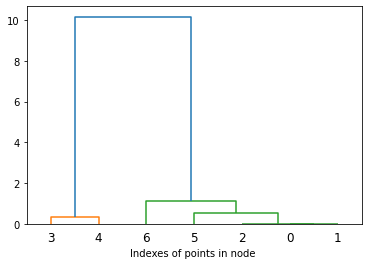

In [50]:
spc.dendrogram(linkage)
plt.xlabel("Indexes of points in node ")
plt.show()